# Image-based Gene Expression Modeling with CLIP Embeddings

This example demonstrates how we can use images as covariates in cEBMF (covariate Empirical Bayes Matrix Factorization). While cEBMF is a flexible tool for incorporating side information into matrix factorization, here we show how to use features extracted from images. Specifically, we use pre-trained CLIP embeddings of these images as covariates. Pre-trained embeddings are powerful because they capture rich, high-level information from images, even when we have limited data or domain expertise. This allows us to leverage knowledge learned from large, general datasets.

Our example comes from genetics: we model gene expression measurements from small regions of tissue, using both the image of each region and its spatial location. However, this approach is broadly applicable—any scenario where you have images (or other complex data types) associated with your samples can benefit. You could also use more domain-specific embeddings (e.g., from a model trained on medical images) if available.

The goal is to make this workflow accessible and adaptable, whether or not you have a background in genetics.

In [12]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import warnings
from tqdm import tqdm
from cebmf_torch import cEBMF
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from contextlib import contextmanager
import sys

In [2]:
class TqdmStdout:
    def __init__(self, total=None, desc=None):
        self.tqdm_bar = tqdm(total=total, desc=desc)
        self._buffer = ""
        self._output = []
    def write(self, s):
        self._buffer += s
        while '\n' in self._buffer:
            line, self._buffer = self._buffer.split('\n', 1)
            self._output.append(line)
            self.tqdm_bar.update(1)
    def flush(self):
        pass  # Needed for compatibility
    def close(self):
        self.tqdm_bar.close()
    @property
    def output(self):
        return self._output

@contextmanager
def tqdm_stdout(total=None, desc=None):
    old_stdout = sys.stdout
    t = TqdmStdout(total=total, desc=desc)
    sys.stdout = t
    try:
        yield t
    finally:
        sys.stdout = old_stdout
        t.close()

First, we load our data. Each data point consists of:
- A small image patch (e.g., a region from a tissue sample)
- The spatial coordinates of that patch (where it came from in the sample)
- A vector of gene expression measurements (how active each gene is in that region)

We visualize a few examples to show how the image, location, and gene expression are related. This helps us understand the data before modeling.

We only use 100 measurements in this example for simplicity, but this could easily be scaled to larger datasets.

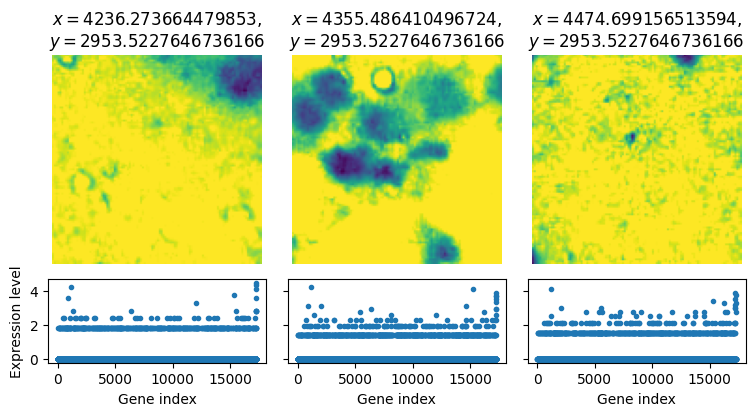

In [3]:
dir1 = '../data/genetics/gene_expression_dataset.pt'
dir2 = '../data/genetics/subimg_coord_dataset.pt'

ged = torch.load(dir1)
scd = torch.load(dir2)
images = []
locs = []
for img, loc in scd:
    images.append(img)
    locs.append(loc)

images = torch.stack(images)
locs = torch.stack(locs)

fig, axs = plt.subplots(2, 3, figsize=(9, 4), sharex='row', sharey='row', gridspec_kw={'height_ratios': [2.5, 1]})
for j in range(3):
    axs[0,j].imshow(torch.squeeze(images[j]))
    title = r'$x = $' + f'{locs[j][0]},\n' + r'$y = $' + f'{locs[j][1]}'
    axs[0,j].set_title(title)
    axs[0,j].axis('off')
    axs[1,j].plot(ged[j], '.')
    axs[1,j].set_xlabel('Gene index')
axs[1,0].set_ylabel('Expression level')
fig.subplots_adjust(hspace=0.1, wspace=0.1)

To make use of the image information, we extract features from each image using a model called CLIP. CLIP is a neural network trained to understand images in a way that relates to human language and concepts. Its embeddings capture high-level information about the image content, even if we don't know exactly what to look for. By using these embeddings as covariates, we hope to better explain patterns in gene expression.

In [4]:

def get_clip_embedding(image_input, model, processor, device):
    """
    Takes a file path, PIL.Image, or torch.Tensor and returns a 512-dim CLIP embedding.
    - Handles grayscale [1,H,W] tensors by repeating channels → [3,H,W].
    - Works on GPU without unnecessary CPU/NumPy conversions.
    """
    # Case 1: file path
    if isinstance(image_input, str):
        image = Image.open(image_input).convert("RGB")

    # Case 2: PIL image
    elif isinstance(image_input, Image.Image):
        if image_input.mode != "RGB":
            image = image_input.convert("RGB")
        else:
            image = image_input

    # Case 3: torch tensor
    elif isinstance(image_input, torch.Tensor):
        image = image_input
        if image.ndim == 4:  # [B,C,H,W], reduce to batch size 1 if needed
            if image.shape[0] == 1:
                image = image.squeeze(0)
            else:
                raise ValueError("Batch tensors not supported here. Pass single image.")
        if image.ndim != 3:
            raise ValueError(f"Expected [C,H,W] tensor, got shape {image.shape}")

        # Grayscale → RGB by channel repeat
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        # Convert tensor to PIL (processor expects PIL or numpy),
        # but keep data on CPU just before feeding
        image = transforms.ToPILImage()(image.cpu())

    else:
        raise TypeError(f"Unsupported input type: {type(image_input)}")

    # Process and get embedding
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_emb = model.get_image_features(**inputs)
        image_emb = image_emb / image_emb.norm(p=2, dim=-1, keepdim=True)  # normalize

    return image_emb.squeeze(0)  # shape: (512,)


### Step 1: Extract CLIP Embeddings for Each Image

We now use the function above to compute a CLIP embedding for every image patch in our dataset. This gives us a numerical summary of each image that can be used as input to our model.

In [5]:
# Load pretrained CLIP
device = "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

clip_embedded_images = []
for image in tqdm(images):
    tempimage = image.squeeze(0).to(device)
    feature_emb = get_clip_embedding(tempimage, clip_model, clip_processor, device) # Extracted features (torch.Tensor) with shape [1,1536]
    clip_embedded_images.append(feature_emb)

clip_embedded_images = torch.stack(clip_embedded_images)  # shape (N, 512)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
100%|██████████| 100/100 [00:04<00:00, 24.33it/s]


In [6]:
clip_embedded_images.shape

torch.Size([100, 512])

# Step 2: Model Gene Expression Using Image and Location Information

Now we combine the CLIP embeddings (image features) and the spatial coordinates for each patch. We use these as covariates in the cEBMF model, which tries to explain the observed gene expression patterns as a combination of underlying factors influenced by these covariates.

In [7]:
Y = torch.stack(ged)
locs = locs.to(device, dtype=clip_embedded_images.dtype)
cov_inputs_clip  = torch.cat([clip_embedded_images, locs], dim=1)

In [8]:
K = 5
niter = 20

cebmf_model_clip = cEBMF(
    data = Y, 
    prior_L="emdn",
    prior_F="norm",
    K = K,
    X_l = cov_inputs_clip,
    X_f = torch.ones(Y.shape[1]),
    device = device,
    self_row_cov = True, 
    self_col_cov = False
)

# Fit
with tqdm_stdout(desc="Fitting cEBMF with CLIP Features", total=niter*7*K) as t:
    fit_clip = cebmf_model_clip.fit(niter)

Fitting cEBMF with CLIP Features: 100%|██████████| 700/700 [01:37<00:00,  7.16it/s]


Check for covergence

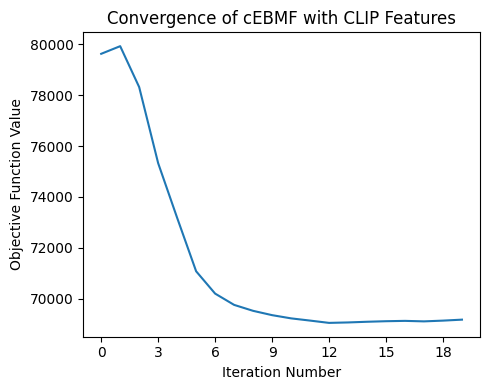

In [14]:
plt.figure(figsize=(5,4))
plt.plot(fit_clip.history_obj)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Iteration Number')
plt.ylabel('Objective Function Value')
plt.title('Convergence of cEBMF with CLIP Features')
plt.tight_layout()

## Comparing Observed and Inferred Gene Expression

This scatter plot compares the gene expression values predicted by our model (using image and location information) to the actual observed values. Each point represents a measurement for a particular gene in a particular region. The results do not need to fall on the one-to-one line (we have no "truth" to compare to here).

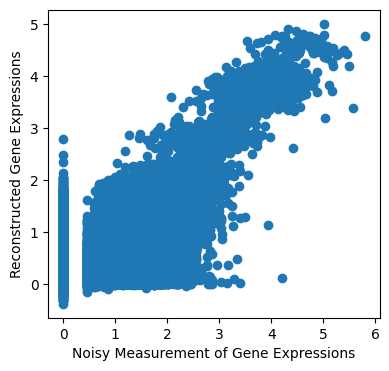

In [10]:
clip_recon = (fit_clip.L @ fit_clip.F.T)

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(Y.numpy().flatten()[:], clip_recon.numpy().flatten()[:],)
ax.set_xlabel('Noisy Measurement of Gene Expressions')
ax.set_ylabel('Reconstructed Gene Expressions')
ax.set_aspect('equal', 'box')
fig.tight_layout()

## Interpreting the Learned Factors

The plots below show several of the "factors" discovered by the cEBMF model. Each factor describes a key pattern or feature present in the dataset—these can be thought of as groups of genes that tend to behave similarly, possibly influenced by image or spatial covariates. 
We see that the first few factors seem to have important features, whereas the latter ones seem less so. We probably only need $K=2$ to describe this dataset.

In real biological data, these factors are often less visually striking than in the other synthetic examples we provide, but they still capture important structure in the data. This is a common challenge when working with real-world datasets!

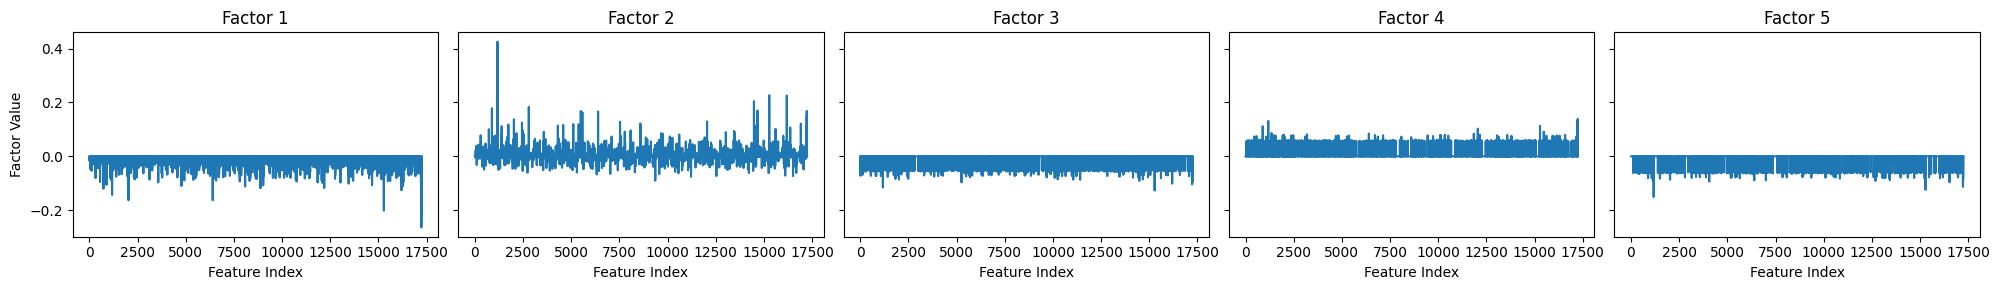

In [11]:
fig, axs = plt.subplots(1, K, figsize=(4*K, 3), sharex=True, sharey=True)

for i in range(len(axs)):

    axs[i].plot(fit_clip.F[:,i].cpu(), label=f'Factor {i+1}')
    axs[i].set_title(f'Factor {i+1}')
    axs[i].set_xlabel('Feature Index')

axs[0].set_ylabel('Factor Value')

fig.tight_layout();